<a href="https://colab.research.google.com/github/Gutzu-Encoder/U-net./blob/main/u_net_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#จะใช้ dataset จาก Oxford-IIIT Pet Dataset
ใช้เพราะง่ายดี load จาก torchvision ได้ + มันเป้น RGB เป็น tensor ที่ input channel ตอนเเรกเป็น 3 อยู่เเล้ว ( บางทีถ้า image เป็น grayscale มันก็จะเป็น 1 ซึ่งถ้าเอาไปทำกับบาง pre-trained model เเบบ resnet 18 ที่ตัวมันเซ็ต input channel เป็น 3 อยู่เเล้วจะลำบาก ต้องมารนั่ง transform กันใหม่) + มันคือ dataset สำหรับทำ image segmentation

ขั้นตอนการทำ data preperation ในการทำ comp vision จะทำการ
- download data มา + define มันเป็น objectๆ นึง
- define dataloader
- Check data ที่ load มาว่ามันออกมาตรงตามที่ต้องการมั้ย ( เห็นว่าทำกับ matplotlib กันเยอะ)

Note: ใน dataset ของ Oxford-IIIT Pet มันเริ่มที่ 1 เเตจริงๆเราต้องให้มันเริ่มที่ 0 เราก็เลยต้อง -1 ไปก่อน

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from PIL import Image


transform_img = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((128, 128), interpolation=Image.NEAREST),
    transforms.PILToTensor()
])

dataset = OxfordIIITPet(root='.', download=True,
                        target_types='segmentation',
                        transform=transform_img,
                        target_transform=transform_mask)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

100%|██████████| 792M/792M [00:36<00:00, 22.0MB/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:01<00:00, 10.3MB/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


In [2]:
import torchvision.transforms.functional as TF

class PetDataset(torch.utils.data.Dataset):
    def __init__(self, root='.', split='train'):
        self.dataset = torchvision.datasets.OxfordIIITPet(
            root=root,
            download=True,
            target_types='segmentation'
        )
        self.transform = transform_img
        self.target_transform = transform_mask

    def __getitem__(self, index):
        img, mask = self.dataset[index]
        img = self.transform(img)
        mask = self.target_transform(mask).squeeze() - 1  # class label ใน dataset มันเริ่มที่ 1 เเต่เราจะใช้มันเป็น 0 ก็ต้องไปลบ
        return img, mask.long()

    def __len__(self):
        return len(self.dataset)

train_set = PetDataset()
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)


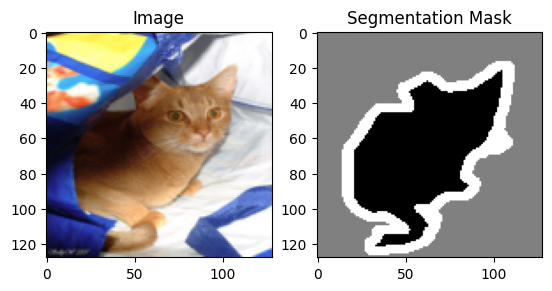

In [3]:
import matplotlib.pyplot as plt
img, mask = dataset[0] #เอาอันเเรก

plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title("Segmentation Mask")
plt.show()

# Define classes
พอเราทำ data preperation เสร็จต่อมาเราจะทำการ define ตัวโมเดล
ข้างในโมเดลก้จะมีการทำงานต่างๆเเบบ conv( จริงๆเป็น conv + relu ถ้าทำ 2 รอบจะเรียกรวมๆเป็น double conv), maxpool , etc.
เราจะ define class การทำงานเเต่ละตัวก่อนเพื่อจะได้เอาไปใส้่ในตัว class ที่เป็นโมเดลใหญ่อีกที

In [4]:
import torch.nn as nn
import torch.nn.functional as F
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


In [5]:
#ขั้น down sample คือขั้นตอน Maxpool
#Is the encoder part
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p # return ตัว down กับ p ออกมาเราจะได้ down คือ DC(x)[คือ Double conv] กับ p คือ P(DC(X))[DC(X)ใส่ Pooling อีกที] btw ไม่ใช่ตัวย่อทางการเเต่เเค่ให้เห็นว่าทำไรกับ x
#down จะไปใช้ใน skip connection ในขั้น decoder อีกที
#p คือ DC(X) ที่ถูก pooling เรจะเอามาใช้ downsample ต่อไปเรื่อยๆจนถึง bottle neck

In [6]:
#ขั้น upsample จะเป็นการ transposed conv-> ก็คือ up ก็คือขยาย
#Is the decoder part
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
#จริงๆไม่ต้องทำ class bottle neck ก้ได้เพราะมันเเค่ double Conv ปกติ
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512) # อย่างที่เห็นว่าตัวขนาดมันจะต้อง relative กันจาก down n ไป down n+1

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        d1, p1 = self.down1(x)
        d2, p2 = self.down2(p1)
        d3, p3 = self.down3(p2)
        d4, p4 = self.down4(p3)

        bn = self.bottleneck(p4)

        u1 = self.up1(bn, d4)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)

        return self.final(u4)

In [8]:
loss_fn = nn.CrossEntropyLoss()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=3, num_classes=3).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
import torch
print(torch.cuda.is_available())  # should return True
print(torch.cuda.get_device_name(0))  # should print GPU name


True
Tesla T4


In [15]:
train_losses = []
val_losses = []  # if you also do validation

def train_model(model, dataloader, loss_fn, optimizer, device="cuda"):
    model.train()
    epoch_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        preds = model(X)              # (B, C, H, W)
        loss = loss_fn(preds, y)      # y is (B, H, W) with class indices

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if batch % 10 == 0:
            print(f"Batch {batch}, Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)


In [16]:
model = UNet(in_channels=3, num_classes=3).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    print(f"Epoch {epoch+1}")
    train_model(model, train_loader, loss_fn, optimizer)

Epoch 1
Batch 0, Loss: 1.0915
Batch 10, Loss: 1.0332
Batch 20, Loss: 0.9883
Batch 30, Loss: 0.9451
Batch 40, Loss: 0.9309
Batch 50, Loss: 0.8014
Batch 60, Loss: 0.8470
Batch 70, Loss: 0.8934
Batch 80, Loss: 0.8478
Batch 90, Loss: 0.9194
Batch 100, Loss: 0.9715
Batch 110, Loss: 0.9128
Batch 120, Loss: 1.0187
Batch 130, Loss: 0.9157
Batch 140, Loss: 0.8185
Batch 150, Loss: 0.7781
Batch 160, Loss: 0.9844
Batch 170, Loss: 0.8707
Batch 180, Loss: 0.8548
Batch 190, Loss: 0.7970
Batch 200, Loss: 0.7253
Batch 210, Loss: 0.8387
Batch 220, Loss: 0.8907
Batch 230, Loss: 0.8282
Batch 240, Loss: 0.9109
Batch 250, Loss: 0.9215
Batch 260, Loss: 0.8771
Batch 270, Loss: 0.9227
Batch 280, Loss: 0.7505
Batch 290, Loss: 0.8606
Batch 300, Loss: 0.6608
Batch 310, Loss: 0.7895
Batch 320, Loss: 0.8800
Batch 330, Loss: 0.8175
Batch 340, Loss: 0.8251
Batch 350, Loss: 0.7753
Batch 360, Loss: 0.8006
Batch 370, Loss: 0.5526
Batch 380, Loss: 0.8815
Batch 390, Loss: 0.7852
Batch 400, Loss: 1.0773
Batch 410, Loss: 0.

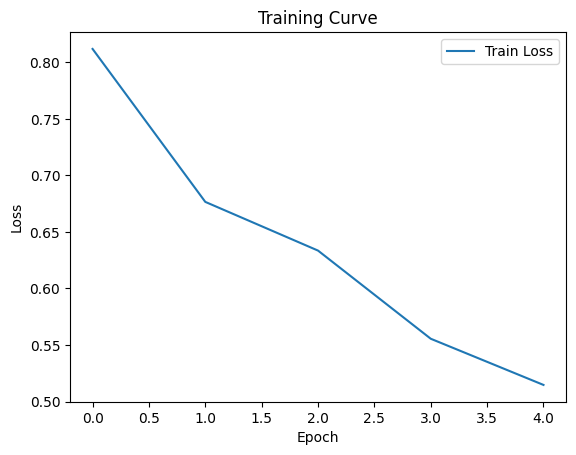

In [17]:
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.legend()
plt.show()


In [18]:
#You’re telling PyTorch to switch the model to evaluation (inference) mode.
model.eval()
#Some layers behave differently during training and evaluation:พวก batch norm กับ dropout


UNet(
  (down1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=Tru

In [19]:
images, masks = next(iter(train_loader))
images, masks = images.to(device), masks.to(device)


In [20]:
with torch.no_grad():
    outputs = model(images)            # shape: (B, C, H, W)
    preds = outputs.argmax(dim=1)      # shape: (B, H, W)


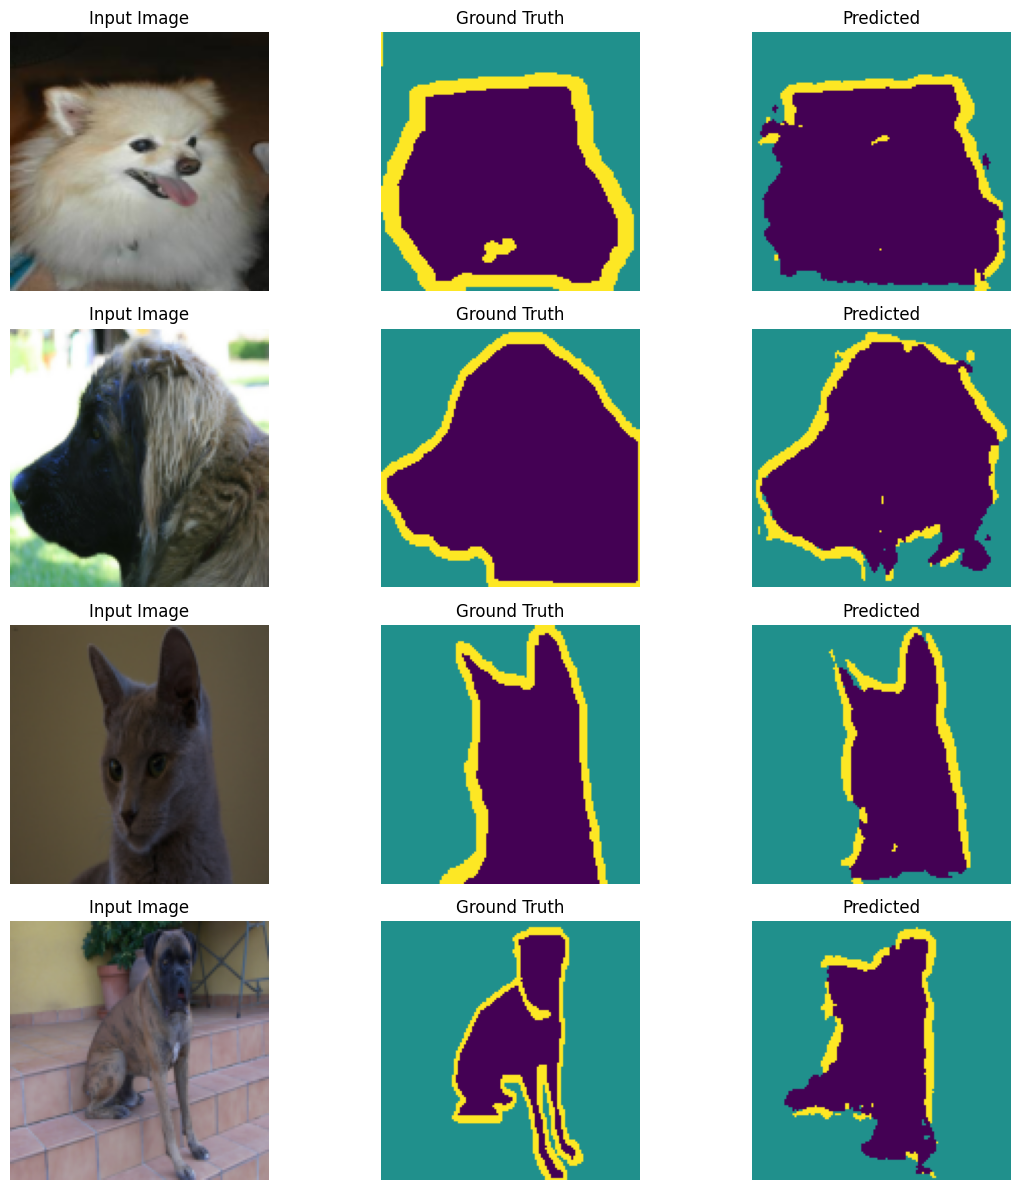

In [21]:
import matplotlib.pyplot as plt

def show_segmentation_results(images, masks, preds, num=4):
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(12, num * 3))

    for i in range(num):
        # Original image
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # (C,H,W) → (H,W,C)
        plt.title("Input Image")
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow(masks[i])
        plt.title("Ground Truth")
        plt.axis('off')

        # Prediction mask
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow(preds[i])
        plt.title("Predicted")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run visualization
show_segmentation_results(images, masks, preds)


In [22]:
import numpy as np
def compute_iou(preds, labels, num_classes):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    for cls in range(num_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        union = (pred_inds | label_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # class not present in either pred or label
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)


In [24]:
model.eval()
ious = []

with torch.no_grad():
    for images, labels in train_loader:  # or train_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)                # (B, C, H, W)
        preds = outputs.argmax(dim=1)         # (B, H, W)

        batch_iou = compute_iou(preds, labels, num_classes=3)
        ious.append(batch_iou)

# Compute average over all batches
mean_iou = np.nanmean(ious)
print(f"Mean IoU (mIoU): {mean_iou:.4f}")


Mean IoU (mIoU): 0.5931


จะเห็นว่าตรงนี้ miou อยุ่ที่ 0.5931 ซึ่งไม่ได้ดีขนาดนั้นเพราะ epoch ที่ไม่เยอะ เเต่เท่นี้ก้สามารถที่จะพอเข้าใจคร่าวๆว่า u-net ทำงานยังไง ส่วนถ้าอยากเพิ่ม accuracy ก้คงต้องลองใช้ epoch ที่มากขึ่น เปลี่ยน loss function หรือให้ดีก็คือทำ transfer learning เอา pre-trained อยู่เเล้วมาใช้เลย